In [65]:
import numpy as np

import matplotlib.pyplot as plt

from collections import namedtuple, Counter
from scipy import stats
from numpy import random
import math


In [29]:
def gen_data(means, samples = 100, n_cluster = 3,sigma = 1.0):
    weights  = np.random.uniform(size = n_cluster
                                )
    weights /= np.sum(weights)
    z = []
    x = []
    classes = np.arange(n_cluster)
    for i in range(samples):
        # Select a class
        z_choice = np.random.choice(classes, p = weights)
        z.append(z_choice)
        
        #Draw an element from the class 
        x_choice = np.random.normal(means[z_choice], sigma)
        x.append(x_choice)
        
    return np.array(x), np.array(z)
    
    

In [30]:
    weights  = np.random.uniform(3)
    weights /= np.sum(weights)
    weights

1.0

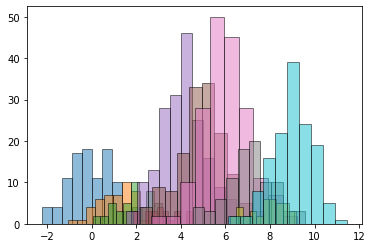

In [31]:
n_classes = 10
means = np.arange(n_classes)
x, z = gen_data(means, samples  =1000, n_cluster = n_classes)

for element in np.arange(n_classes):
    plt.hist(x[z==element], alpha=.5, edgecolor="black")

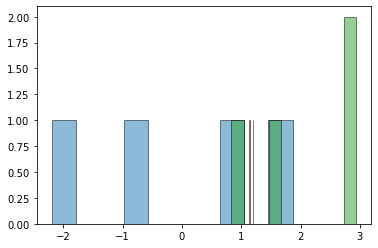

In [32]:
n_classes = 3
means = np.arange(n_classes)
x, z = gen_data(means, samples  =10, n_cluster = n_classes)

for element in np.arange(n_classes):
    plt.hist(x[z==element], alpha=.5, edgecolor="black")

[]

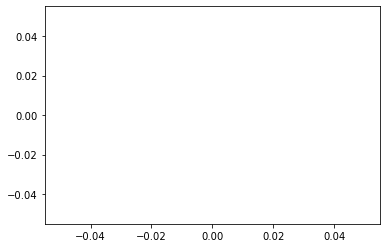

In [33]:
plt.plot()

In [34]:
state = initial_state(x)

# Defining the Gibbs sampler

In [35]:
SuffStat = namedtuple('SuffStat', 'theta N')

def initial_state(data, num_clusters=3, alpha=1., sigma = 1.0):
    cluster_ids = [i for i in range(num_clusters)]
    
    # Defines the current state
    # Sufficient stats are the emprical mean and the assignment of each data point to it
    # Hyper parameters are the parameters of the priors on the paramaters of the data generating distributions
    #(in our case, these are the distribution on the means of the clusters)
    
    # Assignement is the current assigment for each point
    # Pi ar the weights (initialized uniformly)
    # alpha is£ the parameter of the (symmertric) dirichlet prior
    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': sigma,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0.0,
            "variance": 1.0,
        },
        'suffstats': {cid: None for cid in cluster_ids},
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': {cid: alpha / num_clusters for cid in cluster_ids},
    }
    
    update_suffstats(state)
    return state

#WRONG
def update_suffstats(state):
    # Enumerate over the points and determine the cluster it belongs to
    for N, cluster_id in enumerate(state['assignment']):
        points_in_cluster = [x 
            for x, cid in zip(state['data_'], state['assignment'])
            if cid == cluster_id
        ]
        #print("points in cluster", points_in_cluster)
        # Determine the mean of the cluster
        mean = np.array(points_in_cluster).mean()
        
        state['suffstats'][cluster_id] = SuffStat(mean, N)
        print(state['suffstats'][cluster_id])


def update_suffstats(state):
    assignments = np.array(state['assignment'])
    data = state['data_']
    
    #Iterate over each cluster, compute the number of elements and the mean
    for i in state['cluster_ids_']:
        n_points = np.where(assignments == i)[0].shape[0]
        points_in_cluster = data[np.where(assignments == i)[0]]
        mean = np.mean(points_in_cluster)
        
        state['suffstats'][i] = SuffStat(mean, n_points)
        
        

$$
\begin{align}
p(x_i \,|\, \left\{x_j \,|\, z_j=k, j\neq i\right\}, \sigma)
    &= \mathcal{N}(x_i \,|\, \mu_k, \sigma_k^2+\sigma^2)
\end{align}
    $$
    
$$
\begin{align}
p(z_i=k \,|\, z_{\neg i}, \alpha)=
    \frac{N_k^{-i}+\alpha / K}{N-1+\alpha}
\end{align}
    $$

In [36]:
"""
For a given data point, compute the assignemnt score.
"""

def cluster_assignment_distribution(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster, for a given data point
    """
    scores = {}
    
    # Iterate over each cluster
    for cid in state['suffstats'].keys():
        # Since we are in log domain, we add instead of multiply
        #print("score in log domain")
        #print(log_predictive_likelihood(data_id, cid, state), log_cluster_assign_score(cid, state))
        scores[cid] = log_predictive_likelihood(data_id, cid, state)
        scores[cid] += log_cluster_assign_score(cid, state)
    #print(scores)
    # Exponential to go back in normal domain
    scores = {cid: np.exp(score) for cid, score in scores.items()}
    
    # Normalization constant
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in scores.items()}
    return scores

"""
Add or remove a data point (from the sufficient statistics)
"""
def add_datapoint_to_suffstats(x, ss):
    """Add datapoint to sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)+x)/(ss.N+1), ss.N+1)


def remove_datapoint_from_suffstats(x, ss):
    """Remove datapoint from sufficient stats for normal component
    """
    if ss.N > 1:
        theta = (ss.theta*(ss.N)-x*1.0)/(ss.N-1)
    elif ss.N == 1:
        theta = 0
    else: 
        print(error_cluster_size)
    return SuffStat(theta, ss.N-1)



In [37]:
# The prdictive likelihood at a give data point (computed in log domain for stability)
def _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x):
    theta = ss.theta
    #print(math.isnan(theta), ss.theta)
    if math.isnan(ss.theta) == True:
        theta = 0
    if ss.N <= 0:
        theta = 0
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)

    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * theta * 1. / param_var)
    #print(predictive_mu, posterior_sigma2, hp_mean, hp_var, theta, param_var)
    #print(posterior_sigma2 * (hp_mean * 1. / hp_var))
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)

# Computes the log of the quantity above for a given data point
def log_predictive_likelihood(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    # Sufficient stat for cluster num cluster_id
    ss = state['suffstats'][cluster_id]
    
    #Get the hyperparameters
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    
    # The known cluster variance (not learned)
    param_var = state['cluster_variance_']
    
    # Get the data point
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

# compute the second quantity above for a given data point (up to a constant)
def log_cluster_assign_score(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    current_cluster_size = state['suffstats'][cluster_id].N
    num_clusters = state['num_clusters_']
    alpha = state['alpha_']
    return np.log(current_cluster_size + alpha * 1. / num_clusters)

In [38]:
# Take a Gibbs step (no randomness)
def gibbs_step(state):
    pairs = zip(state['data_'], state['assignment'])
    # Iterate over each data point
    for data_id, (datapoint, cid) in enumerate(pairs):
        #print(data_id, (datapoint, cid))
        # Remove the data point from the suff stat
        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, 
                                                                  state['suffstats'][cid])
        
        # Compute the scores
        scores = cluster_assignment_distribution(data_id, state).items()
        
        # Draw a cluster z_i according the scores
        labels, scores = zip(*scores)
        cid = random.choice(labels, p=scores)
        
        # Assign a new cluster
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])

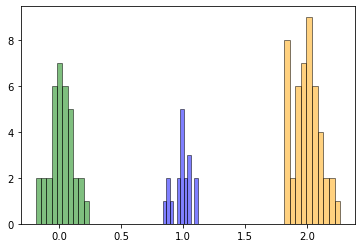

In [60]:
n_classes = 3
means = np.arange(n_classes)
x, z = gen_data(means, samples  =100, n_cluster = n_classes, sigma = 0.1)
color_list = ["green", "blue", "orange", "red"]
for element in np.arange(n_classes):
    plt.hist(x[z==element], alpha=.5, edgecolor="black", color = color_list[element])

In [61]:
state = initial_state(x, sigma = 0.1)

In [62]:
state['cluster_ids_']

[0, 1, 2]

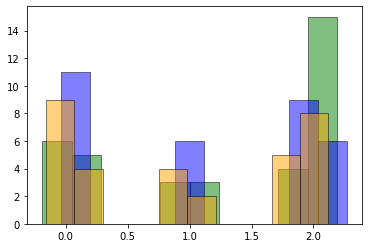

In [63]:
for element in np.arange(n_classes):
    plt.hist(x[state['assignment']==element], alpha=.5, edgecolor="black", color = color_list[element])

In [469]:
state["suffstats"], state['assignment']

({0: SuffStat(theta=1.0029365385078046, N=39),
  1: SuffStat(theta=0.8717841108170424, N=27),
  2: SuffStat(theta=1.0989967211387566, N=34)},
 [2,
  2,
  1,
  0,
  0,
  2,
  1,
  2,
  0,
  1,
  1,
  0,
  2,
  0,
  0,
  1,
  2,
  2,
  0,
  2,
  2,
  1,
  2,
  2,
  0,
  2,
  1,
  0,
  0,
  2,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  1,
  2,
  1,
  1,
  1,
  2,
  0,
  2,
  0,
  1,
  2,
  0,
  2,
  2,
  2,
  1,
  0,
  0,
  0,
  1,
  1,
  2,
  1,
  2,
  0,
  2,
  0,
  0,
  2,
  0,
  0,
  2,
  1,
  2,
  2,
  1,
  0,
  0,
  1,
  1,
  1,
  2,
  0,
  2,
  0,
  2,
  1,
  1,
  2,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  2,
  1])

In [67]:
for i in range(50):
    gibbs_step(state)

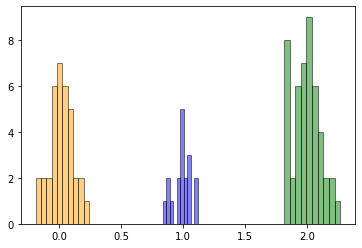

In [68]:
for element in np.arange(n_classes):
    plt.hist(x[state['assignment']==element], alpha=.5, edgecolor="black", color = color_list[element])

In [461]:
state['assignment']

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

# Collapsed Gibbs sampler with DP prior

In [231]:
SuffStat = namedtuple('SuffStat', 'theta N')

def initial_state(data, num_clusters=3, alpha=1., sigma = 1.0):
    cluster_ids = [i for i in range(num_clusters)]
    
    # Defines the current state
    # Sufficient stats are the emprical mean and the assignment of each data point to it
    # Hyper parameters are the parameters of the priors on the paramaters of the data generating distributions
    #(in our case, these are the distribution on the means of the clusters)
    
    # Assignement is the current assigment for each point
    # Pi ar the weights (initialized uniformly)
    # alpha is£ the parameter of the (symmertric) dirichlet prior
    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': sigma,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1.0,
        },
        'suffstats': {cid: None for cid in cluster_ids},
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': {cid: alpha / num_clusters for cid in cluster_ids},
    }
    
    update_suffstats(state)
    return state

def update_suffstats(state):
    assignments = np.array(state['assignment'])
    data = state['data_']
    
    #Iterate over each cluster, compute the number of elements and the mean
    for i in state['cluster_ids_']:
        n_points = np.where(assignments == i)[0].shape[0]
        points_in_cluster = data[np.where(assignments == i)[0]]
        mean = np.mean(points_in_cluster)
        state['suffstats'][i] = SuffStat(mean, n_points)
        
        

In [229]:
# The predictive likelihood at a given data point (computed in log domain for stability)
def _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x):
    theta = ss.theta
    #print(math.isnan(theta), ss.theta)
    if ss.N <= 0:
        theta = 0
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)

    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * theta * 1. / param_var)
    #print(predictive_mu, posterior_sigma2, hp_mean, hp_var, theta, param_var)
    #print(posterior_sigma2 * (hp_mean * 1. / hp_var))
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)

# Computes the log of the quantity above for a given data point
def log_predictive_likelihood(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    # Sufficient stat for cluster num cluster_id
    ss = state['suffstats'][cluster_id]
    
    #Get the hyperparameters
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    
    # The known cluster variance (not learned)
    param_var = state['cluster_variance_']
    
    # Get the data point
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

In [230]:
def log_predictive_likelihood_dp(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the current state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    if cluster_id == "new":
        ss = SuffStat(0, 0)
    else:
        ss = state['suffstats'][cluster_id]
        
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

In [223]:
def log_cluster_assign_score_dp(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    if cluster_id == "new":
        return np.log(state["alpha_"])
    else:
        if state['suffstats'][cluster_id].N == 0:
            return -1e10
        else:
            return np.log(state['suffstats'][cluster_id].N)

In [224]:
#Same as before, with added "new" step
def cluster_assignment_distribution_dp(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    cluster_ids = list(state['suffstats'].keys()) + ['new']
    
    #Compute the scores (multiply not add since we are not in log domain)
    for cid in cluster_ids:
        scores[cid] = log_predictive_likelihood_dp(data_id, cid, state)
        scores[cid] += log_cluster_assign_score_dp(cid, state)
    scores = {cid: np.exp(score) for cid, score in scores.items()}
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in scores.items()}
    return scores

Allows for creation and desctruction of clusters

In [225]:
def create_cluster(state):
    state["num_clusters_"] += 1
    cluster_id = max(state['suffstats'].keys()) + 1
    state['suffstats'][cluster_id] = SuffStat(0, 0)
    state['cluster_ids_'].append(cluster_id)
    state["num_clusters_"] += 1
    return cluster_id

def destroy_cluster(state, cluster_id):
    state["num_clusters_"] -= 1
    del state['suffstats'][cluster_id]
    state['cluster_ids_'].remove(cluster_id)
    
def prune_clusters(state):
    for cid in state['cluster_ids_']:
        if state['suffstats'][cid].N == 0:
            destroy_cluster(state, cid)

Code to sample with collapsed Gibbs with DP prior

In [226]:
def sample_assignment(data_id, state):
    """Sample new assignment from marginal distribution.
    If cluster is "`new`", create a new cluster.
    """
    # Compute the scores
    scores = cluster_assignment_distribution_dp(data_id, state).items()
    labels, scores = zip(*scores)
    
    # Choose a cluster assignment
    cid = random.choice(labels, p=scores)
    if cid == "new":
        return create_cluster(state)
    else:
        return int(cid)

def gibbs_step_dp(state):
    """Collapsed Gibbs sampler for Dirichlet Process Mixture Model
    """
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):
        # Remove the sample form the sufficient stats
        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, state['suffstats'][cid])
        
        #Sample an assignment
        cid = sample_assignment(data_id, state)
        state['assignment'][data_id] = cid
        
        # Add the sample back into the sufficient statistics
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])
        
        #Remove empty clusters
        prune_clusters(state)


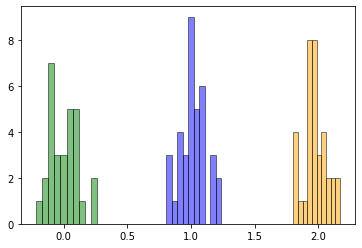

In [227]:
n_classes = 3
means = np.arange(n_classes)
x, z = gen_data(means, samples  =100, n_cluster = n_classes, sigma = 0.1)
color_list = ["green", "blue", "orange", "red"]
for element in np.arange(n_classes):
    plt.hist(x[z==element], alpha=.5, edgecolor="black", color = color_list[element])

In [215]:
state = initial_state(x, num_clusters=2, alpha=1.0, sigma = 0.1)

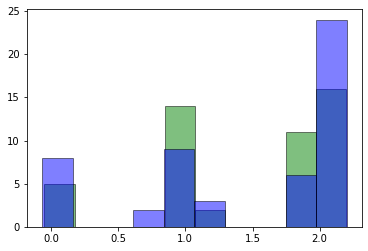

In [216]:
for element in np.arange(n_classes):
    plt.hist(x[state['assignment']==element], alpha=.5, edgecolor="black", color = color_list[element])

In [217]:
state['assignment']

[1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1]

In [218]:
state['cluster_ids_']

[0, 1]

In [219]:
gibbs_step_dp(state)

In [198]:
for i in range(100):
    gibbs_step_dp(state)

In [199]:
state['cluster_ids_']

[0, 1, 2, 5, 6, 7]

In [232]:
state["num_clusters_"]

6

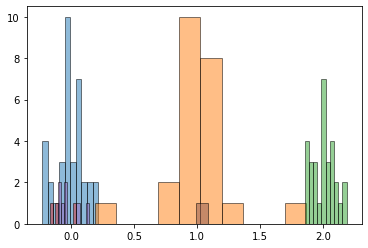

In [200]:
for element in state['cluster_ids_']:
    plt.hist(x[np.array(state['assignment'])==element], alpha=.5, edgecolor="black")

# Pitman-Yor Prior

Everything exactly as before except we add a parameter and modify the score_dp function

In [245]:
SuffStat = namedtuple('SuffStat', 'theta N')

def initial_state(data, num_clusters=3, theta = 1.0, alpha=0, sigma = 1.0):
    cluster_ids = [i for i in range(num_clusters)]
    
    # Defines the current state
    # Sufficient stats are the emprical mean and the assignment of each data point to it
    # Hyper parameters are the parameters of the priors on the paramaters of the data generating distributions
    #(in our case, these are the distribution on the means of the clusters)
    
    # Assignement is the current assigment for each point
    # Pi ar the weights (initialized uniformly)
    # alpha is£ the parameter of the (symmertric) dirichlet prior
    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': sigma,
        'theta': theta,
        'alpha': alpha, # discount parameter
        'hyperparameters_': {
            "mean": 0,
            "variance": 1.0,
        },
        'suffstats': {cid: None for cid in cluster_ids},
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': {cid: alpha / num_clusters for cid in cluster_ids},
    }
    
    update_suffstats(state)
    return state

def update_suffstats(state):
    assignments = np.array(state['assignment'])
    data = state['data_']
    
    #Iterate over each cluster, compute the number of elements and the mean
    for i in state['cluster_ids_']:
        n_points = np.where(assignments == i)[0].shape[0]
        points_in_cluster = data[np.where(assignments == i)[0]]
        mean = np.mean(points_in_cluster)
        state['suffstats'][i] = SuffStat(mean, n_points)
        
        

In [238]:
# The predictive likelihood at a given data point (computed in log domain for stability)
def _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x):
    theta = ss.theta
    #print(math.isnan(theta), ss.theta)
    if ss.N <= 0:
        theta = 0
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)

    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * theta * 1. / param_var)
    #print(predictive_mu, posterior_sigma2, hp_mean, hp_var, theta, param_var)
    #print(posterior_sigma2 * (hp_mean * 1. / hp_var))
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)

# Computes the log of the quantity above for a given data point
def log_predictive_likelihood(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    # Sufficient stat for cluster num cluster_id
    ss = state['suffstats'][cluster_id]
    
    #Get the hyperparameters
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    
    # The known cluster variance (not learned)
    param_var = state['cluster_variance_']
    
    # Get the data point
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

In [239]:
def log_predictive_likelihood_dp(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the current state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    if cluster_id == "new":
        ss = SuffStat(0, 0)
    else:
        ss = state['suffstats'][cluster_id]
        
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

In [364]:
def log_cluster_assign_score_dp(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    # This time take both parameters into account
    if cluster_id == "new":
        return np.log(state["theta"] +state["alpha"]*state["num_clusters_"])
    else:
        if state['suffstats'][cluster_id].N == 0:
            return -1e10
        else:
            return np.log(state['suffstats'][cluster_id].N - state["alpha"])

In [241]:
#Same as before, with added "new" step
def cluster_assignment_distribution_dp(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    cluster_ids = list(state['suffstats'].keys()) + ['new']
    
    #Compute the scores (multiply not add since we are not in log domain)
    for cid in cluster_ids:
        scores[cid] = log_predictive_likelihood_dp(data_id, cid, state)
        scores[cid] += log_cluster_assign_score_dp(cid, state)
    scores = {cid: np.exp(score) for cid, score in scores.items()}
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in scores.items()}
    return scores

Allows for creation and desctruction of clusters

In [242]:
def create_cluster(state):
    state["num_clusters_"] += 1
    cluster_id = max(state['suffstats'].keys()) + 1
    state['suffstats'][cluster_id] = SuffStat(0, 0)
    state['cluster_ids_'].append(cluster_id)
    state["num_clusters_"] += 1
    return cluster_id

def destroy_cluster(state, cluster_id):
    state["num_clusters_"] -= 1
    del state['suffstats'][cluster_id]
    state['cluster_ids_'].remove(cluster_id)
    
def prune_clusters(state):
    for cid in state['cluster_ids_']:
        if state['suffstats'][cid].N == 0:
            destroy_cluster(state, cid)

Code to sample with collapsed Gibbs with PY prior

In [226]:
def sample_assignment(data_id, state):
    """Sample new assignment from marginal distribution.
    If cluster is "`new`", create a new cluster.
    """
    # Compute the scores
    scores = cluster_assignment_distribution_dp(data_id, state).items()
    labels, scores = zip(*scores)
    
    # Choose a cluster assignment
    cid = random.choice(labels, p=scores)
    if cid == "new":
        return create_cluster(state)
    else:
        return int(cid)

def gibbs_step_dp(state):
    """Collapsed PY sampler for Dirichlet Process Mixture Model
    """
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):
        # Remove the sample form the sufficient stats
        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, state['suffstats'][cid])
        
        #Sample an assignment
        cid = sample_assignment(data_id, state)
        state['assignment'][data_id] = cid
        
        # Add the sample back into the sufficient statistics
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])
        
        #Remove empty clusters
        prune_clusters(state)


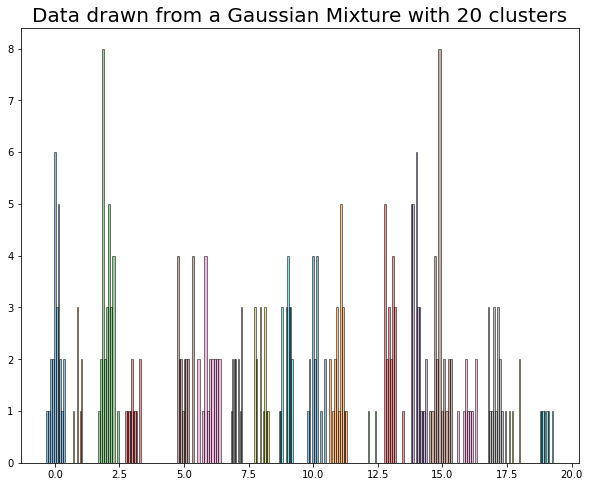

In [396]:
n_classes = 20
means = np.arange(n_classes)
x, z = gen_data(means, samples  =300, n_cluster = n_classes, sigma = 0.2)
color_list = ["green", "blue", "orange", "red"]
plt.figure(figsize = (10,8))
for element in np.arange(n_classes):
    plt.hist(x[z==element], alpha=.5, edgecolor="black", density = False, label = "Cluster {}".format(element))
#plt.legend()
plt.title("Data drawn from a Gaussian Mixture with {} clusters".format(n_classes), size = 20)
plt.show()

## Alpha = 0 (DP)

In [463]:
state = initial_state(x, num_clusters=3, theta=1.0, sigma = 0.2)

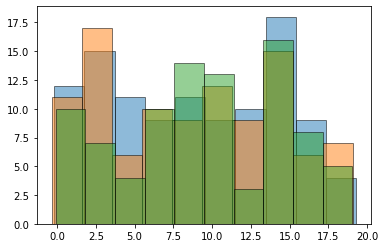

In [464]:
for element in state['cluster_ids_']:
    plt.hist(x[np.array(state['assignment'])==element], alpha=.5, edgecolor="black")

In [465]:
state['cluster_ids_']

[0, 1, 2]

In [466]:
gibbs_step_dp(state)

In [467]:
for i in range(100):
    gibbs_step_dp(state)

In [468]:
state['cluster_ids_']

[0, 1, 2, 4, 6, 22, 28, 29, 30]

In [469]:
len(state['cluster_ids_'])

9

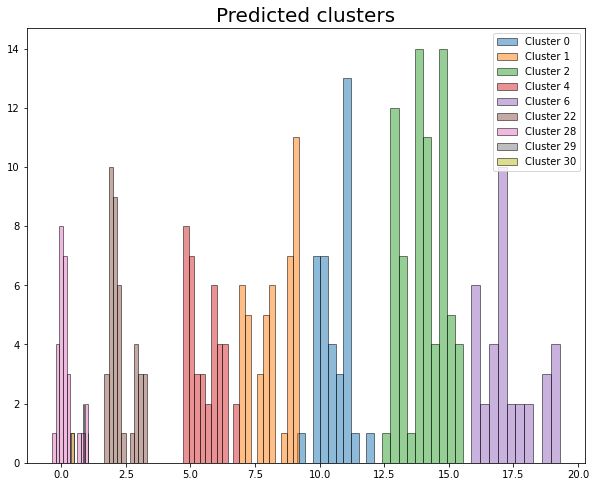

In [470]:
plt.figure(figsize = (10,8))
for element in state['cluster_ids_']:
    plt.hist(x[np.array(state['assignment'])==element], alpha=.5, edgecolor="black", label = "Cluster {}".format(element))
    
plt.legend()
plt.title("Predicted clusters", size = 20)
plt.show()

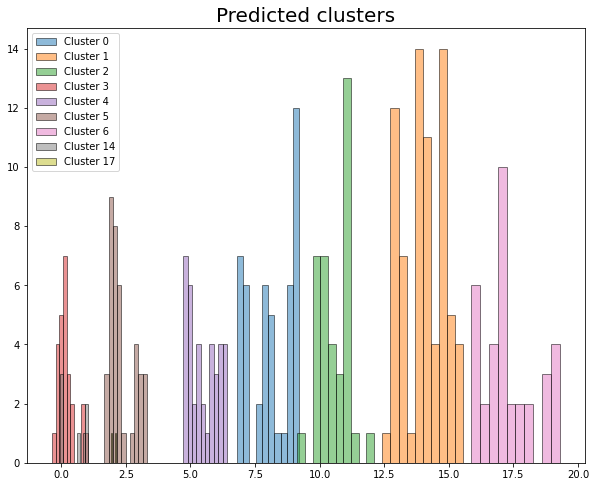

In [437]:
plt.figure(figsize = (10,8))
for element in state['cluster_ids_']:
    plt.hist(x[np.array(state['assignment'])==element], alpha=.5, edgecolor="black", label = "Cluster {}".format(element))
    
plt.legend()
plt.title("Predicted clusters", size = 20)
plt.show()

# Alpha = 0.1 (PY)

In [450]:
state = initial_state(x, num_clusters=3, theta=1.0, alpha = 0.1, sigma = 0.2)

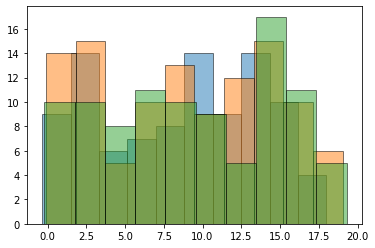

In [451]:
for element in np.arange(n_classes):
    plt.hist(x[state['assignment']==element], alpha=.5, edgecolor="black")

In [452]:
state['cluster_ids_']

[0, 1, 2]

In [453]:
gibbs_step_dp(state)

In [454]:
for i in range(100):
    gibbs_step_dp(state)

In [455]:
state['cluster_ids_']

[0,
 1,
 2,
 4,
 7,
 1916,
 1920,
 1954,
 2016,
 2032,
 2046,
 2049,
 2050,
 2056,
 2058,
 2059,
 2063,
 2064,
 2065,
 2066,
 2067,
 2068,
 2069,
 2070,
 2071,
 2072,
 2073,
 2074,
 2075,
 2076,
 2077,
 2078,
 2079,
 2080,
 2081,
 2082,
 2083,
 2084,
 2085,
 2086,
 2087,
 2088,
 2089,
 2090,
 2091,
 2092,
 2093,
 2094,
 2095,
 2096,
 2097,
 2098,
 2099,
 2100,
 2101]

In [456]:
len(state['cluster_ids_'])

55

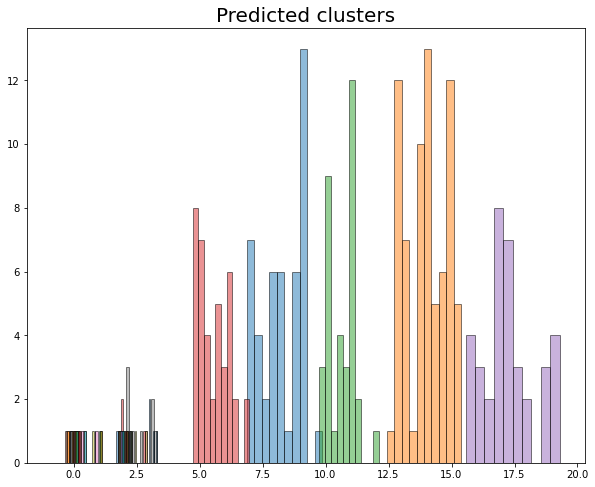

In [457]:
plt.figure(figsize = (10,8))
for element in state['cluster_ids_']:
    plt.hist(x[np.array(state['assignment'])==element], alpha=.5, edgecolor="black", label = "Cluster {}".format(element))
    
plt.title("Predicted clusters", size = 20)
plt.show()

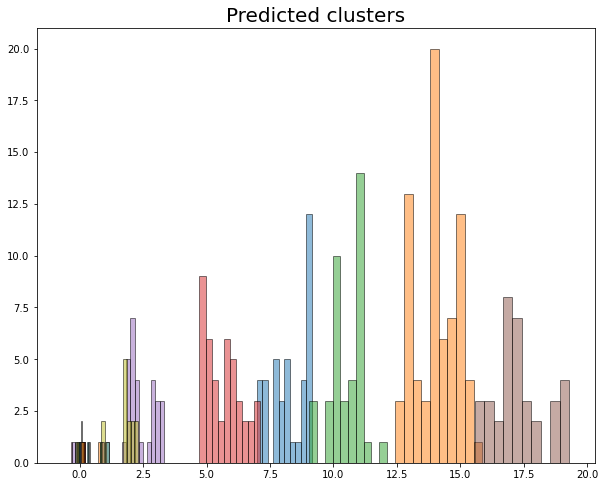

In [447]:
plt.figure(figsize = (10,8))
for element in state['cluster_ids_']:
    plt.hist(x[np.array(state['assignment'])==element], alpha=.5, edgecolor="black", label = "Cluster {}".format(element))
    
plt.title("Predicted clusters", size = 20)
plt.show()

In [449]:
state['suffstats']

{0: SuffStat(theta=8.230146033977409, N=39),
 1: SuffStat(theta=14.034730817496248, N=73),
 2: SuffStat(theta=10.510184972966453, N=39),
 4: SuffStat(theta=5.657775671739725, N=42),
 5: SuffStat(theta=2.434969532495862, N=29),
 6: SuffStat(theta=17.293182155961624, N=35),
 86: SuffStat(theta=-0.06806946350976935, N=2),
 87: SuffStat(theta=0.1107252958816229, N=7),
 93: SuffStat(theta=1.7412941749750843, N=14),
 109: SuffStat(theta=0.2746906864482483, N=3),
 111: SuffStat(theta=-0.042724723206483184, N=3),
 113: SuffStat(theta=0.710405753055237, N=1),
 116: SuffStat(theta=0.4715727279028224, N=2),
 119: SuffStat(theta=0.12051008955645676, N=1),
 120: SuffStat(theta=-0.19704330704259493, N=1),
 122: SuffStat(theta=0.850973309263523, N=1),
 123: SuffStat(theta=-0.033190505185861974, N=1),
 124: SuffStat(theta=0.02289450807625377, N=1),
 125: SuffStat(theta=-0.03270856099251489, N=1),
 126: SuffStat(theta=-0.050030187820271105, N=3),
 127: SuffStat(theta=1.0409420407914685, N=1),
 128: Suf